# A/B testing

## Оценка статистического теста с применением методов частотной нормализации

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.stats import shapiro, levene, ttest_ind

In [ ]:
!pip install bootstrapped

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

Загружаем данные по пользователям и бакетам в структуру pandas.DataFrame().

In [ ]:
data_users = pd.read_csv('/content/hw_abt_2_byuser.csv', sep='\t', index_col=0)
data_buckets = pd.read_csv('/content/hw_abt_2_bybucket.csv', sep='\t')

In [ ]:
data_users.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B


In [ ]:
data_users.shape

(5000, 7)

Распределяем данные пользователей согласно их группам.

In [ ]:
users_A = data_users.loc[data_users['group'] == 'A', :]
users_B = data_users.loc[data_users['group'] == 'B', :]

Рассмотрим диаграммы размаха некоторых метрик.

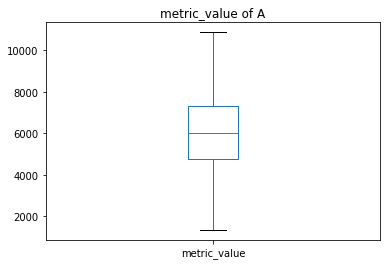

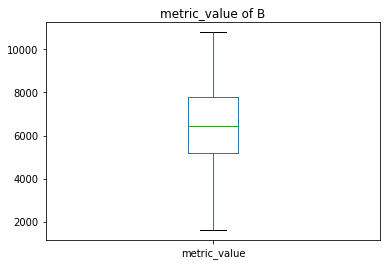

In [ ]:
users_A[['metric_value']].plot.box(title='metric_value of A')
users_B[['metric_value']].plot.box(title='metric_value of B')

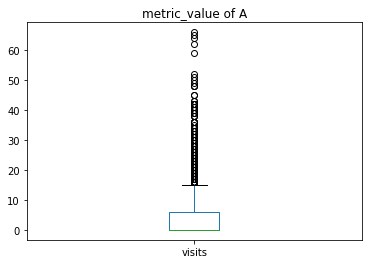

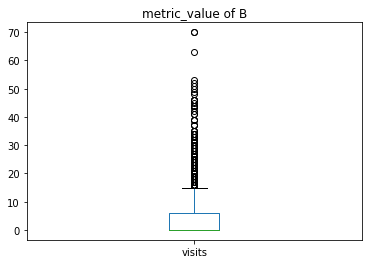

In [ ]:
users_A[['visits']].plot.box(title='metric_value of A')
users_B[['visits']].plot.box(title='metric_value of B')

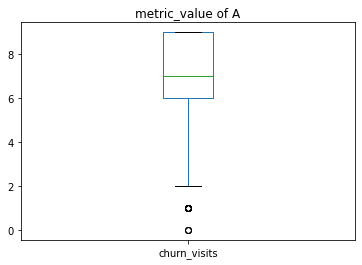

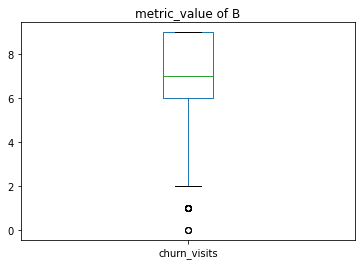

In [ ]:
users_A[['churn_visits']].plot.box(title='metric_value of A')
users_B[['churn_visits']].plot.box(title='metric_value of B')

# 1. Проверка на нормальность распределений метрик и дисперсионный анализ.

Рассмотрим гистограммы распределений метрик.

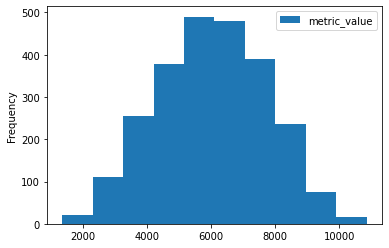

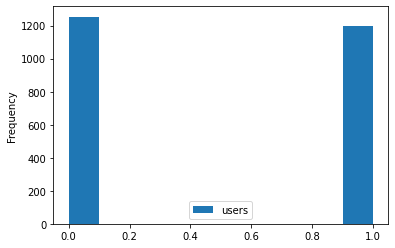

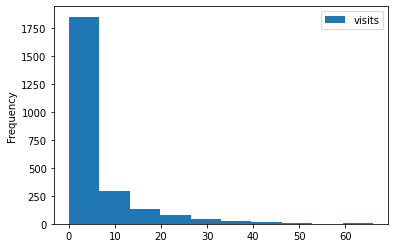

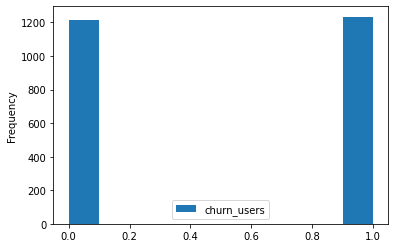

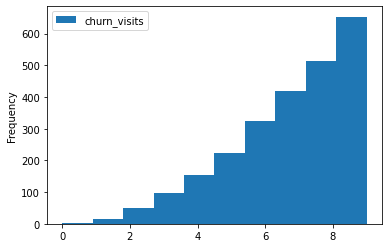

In [ ]:
users_A[['metric_value']].plot.hist()
users_A[['users']].plot.hist()
users_A[['visits']].plot.hist()
users_A[['churn_users']].plot.hist()
users_A[['churn_visits']].plot.hist()

Схожие гистограммы будут наблюдаться и в группе B.
Согласно гистограммам выше, лишь метрика *metric_value* имеет распределение, близкое к нормальному. Докажем, или опровергнем нормальность распределения метрики с помощью критерия Шапиро-Уилкса. Выберем уровень значимости α = 0.05.

In [ ]:
alpha = 0.05

print('Group A:')
st = shapiro(users_A[['metric_value']])
print(st)
print('Distributions is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

print('Group B:')
st = shapiro(users_B[['metric_value']])
print(st)
print('Distributions is {}normal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

Group A:
(0.9951456189155579, 3.546447828739474e-07)
Distributions is not normal

Group B:
(0.9923585057258606, 2.4686641619808825e-10)
Distributions is not normal



Как оказалось, метрика *metric_value* также не распределена нормально. Поэтому при анализе равенства дисперсий будем применять критерий Левена, так как он является менее чувствительным к отклонению распределения от нормального.

In [ ]:
print('metric_value:')
st = levene(users_A[['metric_value']].values.flatten(), users_B[['metric_value']].values.flatten())
print(st)
print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

print('users:')
st = levene(users_A[['users']].values.flatten(), users_B[['users']].values.flatten())
print(st)
print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

print('visits:')
st = levene(users_A[['visits']].values.flatten(), users_B[['visits']].values.flatten())
print(st)
print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

print('churn_users:')
st = levene(users_A[['churn_users']].values.flatten(), users_B[['churn_users']].values.flatten())
print(st)
print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))

print('churn_visits:')
st = levene(users_A[['churn_visits']].values.flatten(), users_B[['churn_visits']].values.flatten())
print(st)
print('Variances of distributions is {}equal\n'.format( {True:'not ', False:''}[st[1] < alpha]))



metric_value:
LeveneResult(statistic=0.8558572644772319, pvalue=0.35494527384691044)
Variances of distributions is equal

users:
LeveneResult(statistic=0.2259561842063439, pvalue=0.6345593771597574)
Variances of distributions is equal

visits:
LeveneResult(statistic=1.4223605587911405, pvalue=0.23307187357888978)
Variances of distributions is equal

churn_users:
LeveneResult(statistic=479.43406390085335, pvalue=1.4725094743068422e-101)
Variances of distributions is not equal

churn_visits:
LeveneResult(statistic=0.0015593409682454862, pvalue=0.9685025059261557)
Variances of distributions is equal



Согласно критерию Левена, лишь дисперсии по метрике *churn_users* в группах A и B не равны. 

# Оценка статистической значимости различий исследуемых метрик в выборках при помощи библиотеки *bootstrapped*.

Будем оценивать средние величины метрик в выборках и сравнивать по процентному изменению этих средних в тестовой выборке относительно контрольной.

Формула для вычисления процентного изменения статистики:

$$ percent\_change = \frac{(test\_stat - ctrl\_stat) * 100.0} {ctrl\_stat}$$

In [ ]:
print(f'\n metric_value:')
print(bs.bootstrap_ab(
    users_B['metric_value'].values,
    users_A['metric_value'].values,
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change,
    num_iterations=5000,
    alpha=0.05,
    iteration_batch_size=100
))

print(f'\n users:')
print(bs.bootstrap_ab(
    users_B['users'].values,
    users_A['users'].values,
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change,
    num_iterations=5000,
    alpha=0.05,
    iteration_batch_size=100
))

print(f'\n visits:')
print(bs.bootstrap_ab(
    users_B['visits'].values,
    users_A['visits'].values,
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change,
    num_iterations=5000,
    alpha=0.05,
    iteration_batch_size=100
))

print(f'\n churn_users:')
print(bs.bootstrap_ab(
    users_B['churn_users'].values,
    users_A['churn_users'].values,
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change,
    num_iterations=5000,
    alpha=0.05,
    iteration_batch_size=100
))

print(f'\n churn_visits:')
print(bs.bootstrap_ab(
    users_B['churn_visits'].values,
    users_A['churn_visits'].values,
    stat_func=bs_stats.mean,
    compare_func=bs_compare.percent_change,
    num_iterations=5000,
    alpha=0.05,
    iteration_batch_size=100
))


 metric_value:
7.197720323707961    (5.531604888738643, 8.827293364359162)

 users:
1.3768237777653305    (-4.6752091673302285, 6.994932270476651)

 visits:
-5.903611421500263    (-15.837768323985735, 3.0601729152705506)

 churn_users:
56.1550498399919    (49.110459478294366, 62.71884529935019)

 churn_visits:
0.7355294540709173    (-0.871211001629929, 2.323123652614588)


Как мы можем заметить статистически значимы метрики *metric_value* и *churn_users*, т.к. доверительный интервал процентилей 0.05 и 0.95 не включает значение 0. <br>

Средние по обеим метрикам увеличились. В случае *metric_value* изменение носит положительный характер (хоть и небольшой), т.к. увеличилось некоторое полезное действие пользователей. Однако нововведение также оказало и отрицательный эффект. Значительно увеличился отток пользователей, представленный метрикой *churn_users*. <br>

(Результаты сходятся с классическими методами оценки стат. значимости)